# Modeling Crop Yield

In [42]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [43]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2"
country_code = "ZMB"
points = "15"
num_features = "1000"
feature_file_name = (f'{satellite}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

weight_file_name = (f'{country_code}_crop_weights{points}k-points')

## Boundaries 

In [44]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [45]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [46]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [47]:
list(set(country_districts) - set(crop_districts))

[]

In [48]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [49]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [50]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [51]:
features = geopandas.GeoDataFrame()
for yr in range(2016, 2019):
    print("Opening:", yr)
    print(f"File: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather") 
    
#     features_x = features_x[(features_x.month == "04") | 
#                             (features_x.month == "05") | 
#                             (features_x.month == "06")]
    
    features_x = features_x.set_index(['lon','lat', "year", 'month']).unstack(fill_value = 0) #fill_value = 0
    features_x.columns = features_x.columns.map(lambda x: '{}_{}'.format(*x))
    features_x = features_x.reset_index()
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    )#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
    features_x = features_x.drop(['lon', 'lat'], axis = 1)
    
    print("Joining:", yr)
    country_x = country_crop[country_crop.year == yr]
    adm_features = features_x.sjoin(country_x, how = 'left', predicate = 'within')
    
    print("Appending:", yr)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], axis = 0), #, ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
File: sentinel-2_ZMB_15k-points_1000-features_2016.feather
Joining: 2016
Appending: 2016
features.shape: (15058, 12005)

Opening: 2017
File: sentinel-2_ZMB_15k-points_1000-features_2017.feather
Joining: 2017
Appending: 2017
features.shape: (30116, 12005)

Opening: 2018
File: sentinel-2_ZMB_15k-points_1000-features_2018.feather
Joining: 2018
Appending: 2018
features.shape: (45174, 12005)



In [52]:
features

,year_left,0_01,0_02,0_03,0_04,0_05,0_06,0_07,0_08,0_09,...,999_07,999_08,999_09,999_10,999_11,999_12,geometry,index_right,year_right,yield_mt
0,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.074053,0.014657,0.012761,0.008725,0.000000,0.065386,POINT (21.98176 -14.01693),NaN,NaN,NaN
1,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000509,0.000323,0.000085,0.008823,0.000000,POINT (21.98287 -15.95433),NaN,NaN,NaN
2,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013470,0.010998,0.011397,0.009623,0.000000,0.008626,POINT (21.98372 -13.92686),NaN,NaN,NaN
3,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.009010,0.008285,0.008821,0.009061,0.000000,POINT (21.98510 -15.86427),NaN,NaN,NaN
4,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011034,0.010122,0.010264,0.008985,0.000000,0.008561,POINT (21.98566 -13.83679),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45169,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300740,0.341496,0.058969,0.053973,0.103395,0.350005,POINT (33.54503 -10.56450),Isoka,2018.0,3.400556
45170,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.172033,0.176245,0.022074,0.011757,0.054800,0.239189,POINT (33.54695 -10.65435),Isoka,2018.0,3.400556
45171,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180134,0.215340,0.026935,0.022201,0.216269,0.122370,POINT (33.58948 -10.51863),Isoka,2018.0,3.400556
45172,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.230495,0.271054,0.062754,0.073630,0.316358,0.236825,POINT (33.59140 -10.60847),Chama,2018.0,1.668139


In [53]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [54]:
#features['year_right']
features = features.dropna(subset = ['index_right']).drop(columns = ['year_right']).rename(columns = {'index_right': 'district', 'year_left':'year'}).reset_index(drop = True)
#features = features.dropna(subset=['index_right']).drop(['year_right', "index_3", "index_4", "index_5", "index_6"], axis = 1).rename(columns = {"index_right": "district", "year_left": "year"}).reset_index(drop = True)

In [55]:
features

,year,0_01,0_02,0_03,0_04,0_05,0_06,0_07,0_08,0_09,...,999_06,999_07,999_08,999_09,999_10,999_11,999_12,geometry,district,yield_mt
0,2016,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007433,0.006524,0.001714,0.001303,0.001191,0.000000,0.000000,POINT (22.00038 -15.23385),Kalabo,0.379483
1,2016,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.083997,0.011810,0.014378,0.024008,0.000000,0.000000,POINT (22.00069 -13.11618),Chavuma,2.806322
2,2016,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.059781,0.036281,0.001994,0.001333,0.008094,0.000000,0.000000,POINT (22.00250 -15.14378),Kalabo,0.379483
3,2016,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.065703,0.002909,0.003077,0.005078,0.000000,0.000000,POINT (22.00251 -13.02610),Chavuma,2.806322
4,2016,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033179,0.099256,0.012210,0.010873,0.015264,0.000000,0.000000,POINT (22.00461 -15.05372),Kalabo,0.379483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44860,2018,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.491026,0.300740,0.341496,0.058969,0.053973,0.103395,0.350005,POINT (33.54503 -10.56450),Isoka,3.400556
44861,2018,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.420190,0.172033,0.176245,0.022074,0.011757,0.054800,0.239189,POINT (33.54695 -10.65435),Isoka,3.400556
44862,2018,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.381572,0.180134,0.215340,0.026935,0.022201,0.216269,0.122370,POINT (33.58948 -10.51863),Isoka,3.400556
44863,2018,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.465889,0.230495,0.271054,0.062754,0.073630,0.316358,0.236825,POINT (33.59140 -10.60847),Chama,1.668139


In [56]:
#features['999_3'][0]

In [57]:
#features['999_4'][0]

In [58]:
#features['999_5'][0]

In [59]:
#features['999_6'][0]

In [60]:
#features[features.year == 2017]

In [ ]:
if satellite == "landsat-8-c2-l2":
    na = features[features.isna().any(axis = 1)]
    na.plot(figsize = (15,15), markersize = 1)
    # plt.savefig(f'images/nans.jpg', dpi=300)
    features = features.dropna()

In [ ]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

In [61]:
# this summarizes the features to the district level
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

## Model

In [62]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [64]:
len(y_all)

216

In [65]:
len(x_train)

172

In [66]:
len(x_test)

44

In [67]:
#build the model
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
#fit the model
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [68]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.35


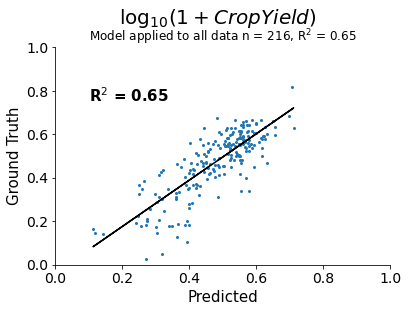

In [69]:
#predict on x_all

y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

plt.figure()
plt.scatter(y_pred, y_all, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to all data n = {len(x_all)}, R$^2$ = {(r2_score(y_all, y_pred)):0.2f}",
          fontsize=12, y=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.text(0.1, .75,
         s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
         fontsize=15, fontweight="bold")

m, b = np.polyfit(y_pred, y_all, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.show()
plt.close()

In [72]:
country_shp

,geometry
district,
Chibombo,"POLYGON ((28.57140 -15.16934, 28.56550 -15.168..."
Kabwe,"POLYGON ((28.16380 -14.61242, 28.17033 -14.608..."
Kapiri Mposhi,"POLYGON ((27.10976 -14.39606, 27.11129 -14.377..."
Mkushi,"POLYGON ((29.60834 -13.22694, 29.60992 -13.227..."
Mumbwa,"POLYGON ((27.76537 -15.63295, 27.75983 -15.633..."
...,...
Lukulu,"POLYGON ((23.67353 -14.60998, 23.66011 -14.613..."
Mongu,"POLYGON ((23.05670 -14.80501, 23.06543 -14.805..."
Senanga,"POLYGON ((24.60805 -15.50520, 24.59986 -15.511..."


<AxesSubplot:>

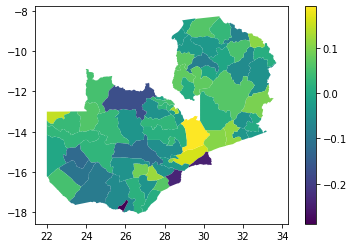

In [83]:
residual_df = pd.DataFrame()

residual_df["yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
residual_gdf = geopandas.GeoDataFrame(residual_df)
residual_gdf[residual_gdf.year == 2016].plot(column = "residual", legend = True)

In [26]:
# spearmanr(y_pred, y_all)

In [27]:
# pearsonr(y_pred, y_all)

In [28]:
# spearmanr(y_pred, y_all)

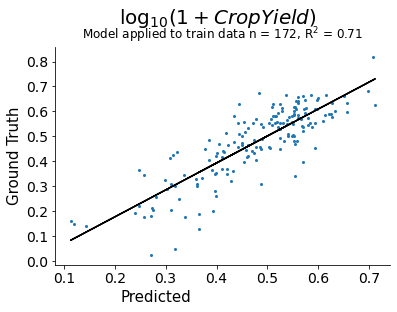

In [29]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [30]:
r2_score(y_train, y_pred)

0.7078512737676306

In [31]:
pearsonr(y_pred, y_train)

(0.843673195931387, 8.607249368880632e-48)

In [32]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.8128426995705422, pvalue=9.396567478603806e-42)

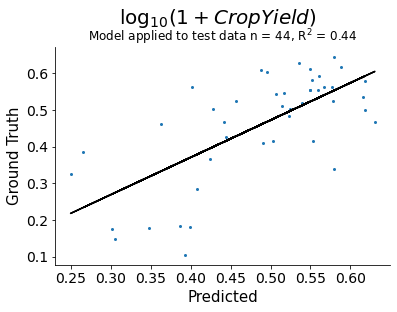

In [33]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [41]:
residual_df = 

NameError: name 'join' is not defined

In [34]:
r2_score(y_test, y_pred)

0.4379117288160215

In [35]:
pearsonr(y_pred, y_test)

(0.6884238866259781, 2.406952667239926e-07)

In [36]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.6163495419309373, pvalue=8.412137105722056e-06)

In [37]:
pred_features = features.copy()
x_all = pred_features.drop(['year', 'geometry', 'district', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [38]:
#pred_features['std_error'] = np.maximum(ridge_cv_random.(x_all), 0)

In [39]:
plot_features = pred_features[pred_features.year == 2016]
# pred_features

<AxesSubplot:>

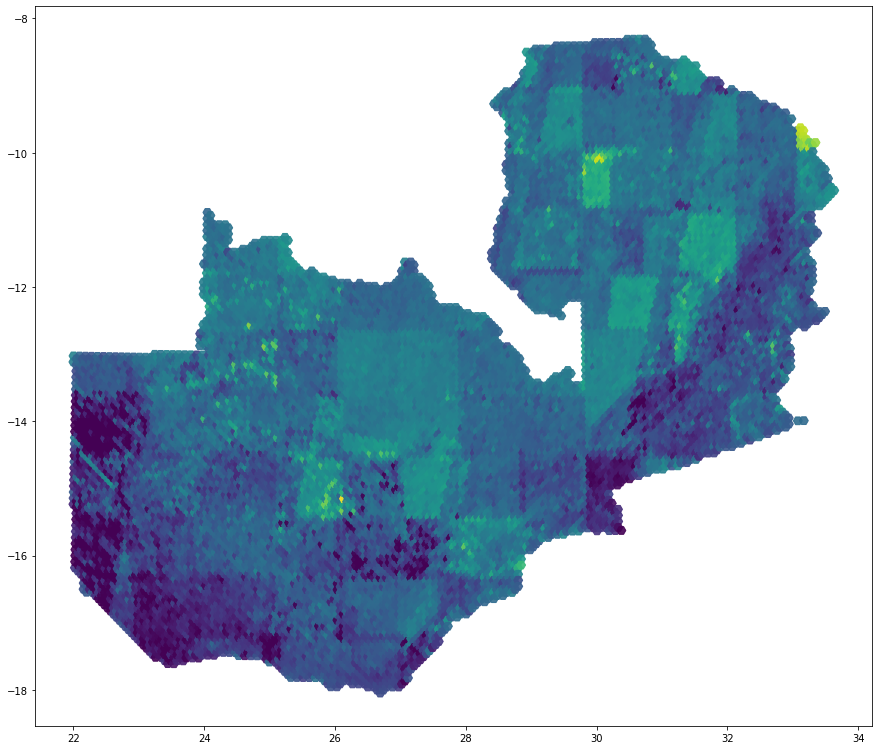

In [40]:
plot_features.plot(figsize = (15,15),
                   marker='H',
                   # legend = True,
                   markersize = 80,
                   alpha = .9,
                   column = 'fit')